In [1]:
import os, math
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pickle
import random as rn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split 
from keras.layers.advanced_activations import LeakyReLU
from keras import regularizers

pd.set_option('display.max_columns', 200)
print(tf.__version__)

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

Using TensorFlow backend.


2.0.0


In [2]:
def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    rn.seed(seed) # random関数のシードを固定
    np.random.seed(seed) # numpyのシードを固定
    tf.random.set_seed(seed) # tensorflowのシードを固定

In [42]:
def yyplot(y_true, y_pred):
    yvalues = np.concatenate([y_true.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    fig = plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, s=1.0)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01], color="red", linestyle = "dashed")
    plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('t: true value')
    plt.ylabel('y: predicted value')
    plt.title('True-Predicted Plot')
    plt.grid(True)
    plt.show()
    return fig

In [4]:
def metrics(y_true, y_pred):
    metrics = [r2_score(y_true=y_true, y_pred=y_pred), 
               np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred)), 
               mean_absolute_error(y_true=y_true, y_pred=y_pred)
              ]
    return metrics

In [5]:
# シードの固定
reset_seed(1234)

In [6]:
#data_dir = r'C:\Users\BF427\OneDrive - Chiyoda Corporation\Documents\_10008948_IoT_Process_fusion\FY_2021\MonitoringAI_CPW-main_20210818\DataForFSI4135'
data_dir = r'..\..\..\DataForFSI4135'
data_filelist = os.listdir(data_dir)
file_num = len(data_filelist)
print("file_num:",file_num)
print(data_filelist)

# Read Data and Integrate into 1 Data Frame
df_raw = pd.DataFrame()
for i_file in range(file_num):
    file_dir = data_dir + "/" + data_filelist[i_file]
    #print(file_dir)
    print(data_filelist[i_file])
    df_tmp = pd.read_pickle(file_dir)
    df_raw = pd.concat([df_raw, df_tmp])
df_raw.reset_index(drop=True, inplace=True)
print("df_raw.shape:", df_raw.shape)

file_num: 10
['Data_for_FSI4135_01.pkl', 'Data_for_FSI4135_02.pkl', 'Data_for_FSI4135_03.pkl', 'Data_for_FSI4135_04.pkl', 'Data_for_FSI4135_05.pkl', 'Data_for_FSI4135_06.pkl', 'Data_for_FSI4135_07.pkl', 'Data_for_FSI4135_08.pkl', 'Data_for_FSI4135_09.pkl', 'Data_for_FSI4135_10.pkl']
Data_for_FSI4135_01.pkl
Data_for_FSI4135_02.pkl
Data_for_FSI4135_03.pkl
Data_for_FSI4135_04.pkl
Data_for_FSI4135_05.pkl
Data_for_FSI4135_06.pkl
Data_for_FSI4135_07.pkl
Data_for_FSI4135_08.pkl
Data_for_FSI4135_09.pkl
Data_for_FSI4135_10.pkl
df_raw.shape: (306280, 90)


In [7]:
df_raw.describe()

,TI_4124.PV,LC_4103.PV,LC_4105.PV,LC_4105.OP,PC_4108.PV,TI_4127.PV,LC_4109.PV,TI_4128.PV,FI_4118.PV,TI_4132.PV,TI_4131.PV,LC_4119.PV,TI_4133.PV,FC_4136.PV,FI_4120.PV,LC_4120.PV,TI_4134.PV,TI_4190.PV,PC_4111.PV,PC_4111.OP,TI_4135.PV,TI_4165.PV,TI_4152.PV,TI_4164.PV,TI_4159.PV,TI_4160.PV,TI_4163.PV,TI_4136.PV,TI_4140.PV,TC_4120.PV,TI_4137.PV,TI_4138.PV,TI_4162.PV,TI_4161.PV,TI_4139.PV,PC_4120.PV,FI_4149.PV,PC_4114.PV,FC_4121.PV,FC_4122.PV,FC_4123.PV,FC_4124.PV,TC_4121.PV,TI_4141.PV,TI_4142.PV,TI_4180.PV,TI_4143.PV,TI_4146.PV,TC_4158.PV,FC_4138.PV,TI_4148.PV,TI_4147.PV,FC_4137.PV,TI_4144.PV,PC_4112.PV,LC_4123.PV,FC_4125.PV,FC_4126.PV,LC_4122.PV,PC_4112.OP,PC_4112.OP_1,PI_4128.PV,TI_4145.PV,LC_4124.PV,LC_4125.PV,FC_4132.PV,FSI4170.PV,FSI4133.PV,TI_4150.PV,LC_4122.OP,TI_4101.PV,FI_4117.PV,LC_4101.PV,LC_4101.OP,TI_4102.PV,FSI4101.PV,PC_4102.PV,LIX41022.PV,LIX41023.PV,AI_41021.PV,AI_41022.PV,FI_4134.PV,FSI4135.PV,TI_4151.PV,PCX4129.PV,PQ_62003.PV,PQ_62004.PV,FC_61001.PV,HC_4113.OP,TI_4191.PV
count,306264.000000,305976.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,306244.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,306262.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,306262.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,306261.000000,306258.000000,306267.000000,304550.000000,304454.000000,304455.000000,304453.000000,306241.000000,306267.000000,305381.000000,306267.000000,306267.000000,306267.000000,300481.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,302650.000000,306263.000000,306267.000000,253424.000000,306267.000000,306266.000000,306263.000000,306267.000000,306267.000000,305989.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,306267.000000,306248.000000,306267.000000,306257.000000,306266.000000,306267.000000,306267.000000,306267.000000,306235.000000,306267.000000,305879.000000,306267.000000,306267.000000,306267.000000,306268.000000,306268.000000,306268.000000,306267.000000,306267.000000
mean,193.509633,49.699811,49.756631,68.053066,0.747517,34.621767,51.410568,35.187579,2.651408,170.526352,122.973509,49.896187,186.882838,2.279714,598.391724,45.496446,34.719326,214.631296,0.449507,65.940205,299.306950,313.305059,319.619056,654.448387,402.381012,402.607777,633.983089,357.596379,356.240695,355.072289,355.494035,355.587248,394.709827,396.814862,356.704641,0.047933,1625.961206,0.021651,72.612123,72.630411,72.603179,72.621614,117.927399,117.986273,233.177515,231.447803,351.415057,321.131682,328.133759,0.372207,218.613811,218.537361,4.355647,342.505452,0.070268,49.467456,42.517208,41.996945,50.238094,48.067266,47.845358,0.071503,29.168351,48.321099,49.320383,29.342384,6.947514,21.795674,29.092619,49.523851,90.265451,6.179122,59.698027,61.371330,162.398572,272.269687,0.200082,99.786087,99.999573,0.453409,915.407671,201.582265,205.139974,70.707325,1.379234,3.737636,17.614941,5.550102,26.820530,123.754600
std,20.433965,1.953504,2.537634,9.883618,0.030536,3.245313,3.406843,3.040735,1.656019,20.885246,21.975644,2.363769,19.812211,0.317921,161.877138,3.914962,4.708019,21.705971,0.029682,27.588879,26.783888,28.080988,33.759780,75.398022,36.523700,36.302603,68.411446,30.830355,30.399792,30.290400,30.577035,30.514832,35.059417,35.191856,30.738142,0.015032,329.323126,0.005183,14.449486,14.396694,14.404248,14.401656,9.772463,9.897349,16.753229,20.668335,30.145580,36.544267,6.161147,0.206018,26.160032,27.576517,0.913698,28.620712,0.005187,5.914458,10.610600,11.265328,3.008553,4.615520,4.557683,0.008047,3.394811,5.746365,5.535601,12.015172,8.881694,17.870179,4.618878,8.135078,10.472103,8.908776,3.924443,10.603958,15.194447,61.272427,0.001954,0.924932,0.137085,0.194515,13.365417,41.109976,46.582413,7.781996,

In [8]:
df = df_raw.copy()
df.reset_index(inplace=True, drop=True)
df.dropna(inplace=True)

In [9]:
df.describe()

,TI_4124.PV,LC_4103.PV,LC_4105.PV,LC_4105.OP,PC_4108.PV,TI_4127.PV,LC_4109.PV,TI_4128.PV,FI_4118.PV,TI_4132.PV,TI_4131.PV,LC_4119.PV,TI_4133.PV,FC_4136.PV,FI_4120.PV,LC_4120.PV,TI_4134.PV,TI_4190.PV,PC_4111.PV,PC_4111.OP,TI_4135.PV,TI_4165.PV,TI_4152.PV,TI_4164.PV,TI_4159.PV,TI_4160.PV,TI_4163.PV,TI_4136.PV,TI_4140.PV,TC_4120.PV,TI_4137.PV,TI_4138.PV,TI_4162.PV,TI_4161.PV,TI_4139.PV,PC_4120.PV,FI_4149.PV,PC_4114.PV,FC_4121.PV,FC_4122.PV,FC_4123.PV,FC_4124.PV,TC_4121.PV,TI_4141.PV,TI_4142.PV,TI_4180.PV,TI_4143.PV,TI_4146.PV,TC_4158.PV,FC_4138.PV,TI_4148.PV,TI_4147.PV,FC_4137.PV,TI_4144.PV,PC_4112.PV,LC_4123.PV,FC_4125.PV,FC_4126.PV,LC_4122.PV,PC_4112.OP,PC_4112.OP_1,PI_4128.PV,TI_4145.PV,LC_4124.PV,LC_4125.PV,FC_4132.PV,FSI4170.PV,FSI4133.PV,TI_4150.PV,LC_4122.OP,TI_4101.PV,FI_4117.PV,LC_4101.PV,LC_4101.OP,TI_4102.PV,FSI4101.PV,PC_4102.PV,LIX41022.PV,LIX41023.PV,AI_41021.PV,AI_41022.PV,FI_4134.PV,FSI4135.PV,TI_4151.PV,PCX4129.PV,PQ_62003.PV,PQ_62004.PV,FC_61001.PV,HC_4113.OP,TI_4191.PV
count,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000
mean,196.159760,49.847147,49.996627,68.957042,0.749831,34.748279,51.138573,35.477402,2.774032,173.265945,124.397799,49.894369,189.052640,2.299805,615.544226,45.315773,35.096756,216.160173,0.452072,68.167134,302.837177,316.361122,321.069104,661.395612,406.631109,406.961952,641.581281,361.303701,360.059603,358.900987,359.410828,359.410568,399.164830,401.321921,360.681191,0.049402,1635.870062,0.021851,73.021386,73.012239,72.987896,73.005669,118.870515,118.883008,234.017361,232.509445,355.284566,326.324314,328.450543,0.403105,220.581979,222.210981,4.383454,346.201422,0.070383,50.224901,43.367412,43.340815,50.468008,48.292024,48.292024,0.071326,29.263459,48.653871,49.826814,28.170842,8.077273,19.370505,29.391164,49.341385,90.891998,6.315602,59.731085,61.611272,163.619236,275.643716,0.200085,99.896465,99.999515,0.465081,917.028336,202.658866,207.796927,71.253058,1.400600,3.793679,17.103190,6.166164,27.382296,124.781421
std,6.073095,0.752849,1.218458,5.321692,0.002133,2.200051,2.611764,1.789647,1.595294,6.724814,20.220554,1.739170,6.432920,0.235660,146.203860,3.574566,4.215081,7.796565,0.004424,26.995095,8.326607,10.564155,22.988605,45.123951,9.166699,8.004053,34.096437,3.417374,2.678051,2.698894,3.002825,2.929118,6.947482,6.670529,3.339290,0.015084,257.720322,0.005117,13.670936,13.679077,13.690453,13.687287,1.421606,1.626389,7.804518,9.107990,2.843979,6.137231,6.174724,0.216960,10.460146,3.031044,0.773162,2.466135,0.001920,2.349227,10.042074,9.752425,2.641310,3.809269,3.809269,0.006775,3.058508,3.541834,2.657679,11.072629,9.088980,17.623670,4.142609,7.834082,9.724972,9.356363,3.572939,8.804188,5.213701,50.352447,0.002006,0.413167,0.152329,0.200325,10.817774,38.390342,38.763432,6.959986,0.139002,7.256579,24.3462

In [10]:
df.shape

(247892, 90)

In [11]:
# explanatory variable - given
list_x = [
    'LC_4103.PV',
    'LC_4105.PV',
    'LC_4105.OP',
    'PC_4108.PV',
    'LC_4109.PV',
    'TI_4128.PV',
    'FI_4118.PV',
    'TI_4132.PV',
    'TI_4131.PV',
    'LC_4119.PV',
    'FI_4120.PV',
    'LC_4120.PV',
    'TI_4134.PV',
    'TI_4190.PV',
    'PC_4111.PV',
    'TI_4152.PV',
    'TI_4164.PV',
    'TI_4159.PV',
    'TI_4163.PV',
    'TI_4136.PV',
    'TC_4120.PV',
    'TI_4162.PV',
    'TI_4139.PV',
    'PC_4120.PV',
    'PC_4114.PV',
    'FC_4121.PV',
    'FC_4122.PV',
    'FC_4123.PV',
    'FC_4124.PV',
    'TC_4121.PV',
    'TI_4142.PV',
    'TI_4180.PV',
    'TC_4158.PV',
    'FC_4138.PV',
    'TI_4147.PV',
    'FC_4137.PV',
    'PC_4112.PV',
    'LC_4123.PV',
    'FC_4126.PV',
    'LC_4122.PV',
    'PI_4128.PV',
    'TI_4145.PV',
    'LC_4124.PV',
    'LC_4125.PV',
    'FC_4132.PV',
    'FSI4170.PV',
    'TI_4150.PV',
    'LC_4122.OP',
    'TI_4101.PV',
    'FI_4117.PV',
    'LC_4101.PV',
    'LC_4101.OP',
    'TI_4102.PV',
    'FSI4101.PV',
    'PC_4102.PV',
    'LIX41022.PV',
    'AI_41021.PV',
    'TI_4151.PV',
    'PQ_62003.PV',
    'PQ_62004.PV',
    'FC_61001.PV',
    'HC_4113.OP',
    'TI_4191.PV'
]

# Target variable
list_y = [
    'FSI4135.PV' 
]

In [12]:
df_x = df.loc[:, list_x]
df_x.describe()

,LC_4103.PV,LC_4105.PV,LC_4105.OP,PC_4108.PV,LC_4109.PV,TI_4128.PV,FI_4118.PV,TI_4132.PV,TI_4131.PV,LC_4119.PV,FI_4120.PV,LC_4120.PV,TI_4134.PV,TI_4190.PV,PC_4111.PV,TI_4152.PV,TI_4164.PV,TI_4159.PV,TI_4163.PV,TI_4136.PV,TC_4120.PV,TI_4162.PV,TI_4139.PV,PC_4120.PV,PC_4114.PV,FC_4121.PV,FC_4122.PV,FC_4123.PV,FC_4124.PV,TC_4121.PV,TI_4142.PV,TI_4180.PV,TC_4158.PV,FC_4138.PV,TI_4147.PV,FC_4137.PV,PC_4112.PV,LC_4123.PV,FC_4126.PV,LC_4122.PV,PI_4128.PV,TI_4145.PV,LC_4124.PV,LC_4125.PV,FC_4132.PV,FSI4170.PV,TI_4150.PV,LC_4122.OP,TI_4101.PV,FI_4117.PV,LC_4101.PV,LC_4101.OP,TI_4102.PV,FSI4101.PV,PC_4102.PV,LIX41022.PV,AI_41021.PV,TI_4151.PV,PQ_62003.PV,PQ_62004.PV,FC_61001.PV,HC_4113.OP,TI_4191.PV
count,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000,247892.000000
mean,49.847147,49.996627,68.957042,0.749831,51.138573,35.477402,2.774032,173.265945,124.397799,49.894369,615.544226,45.315773,35.096756,216.160173,0.452072,321.069104,661.395612,406.631109,641.581281,361.303701,358.900987,399.164830,360.681191,0.049402,0.021851,73.021386,73.012239,72.987896,73.005669,118.870515,234.017361,232.509445,328.450543,0.403105,222.210981,4.383454,0.070383,50.224901,43.340815,50.468008,0.071326,29.263459,48.653871,49.826814,28.170842,8.077273,29.391164,49.341385,90.891998,6.315602,59.731085,61.611272,163.619236,275.643716,0.200085,99.896465,0.465081,71.253058,3.793679,17.103190,6.166164,27.382296,124.781421
std,0.752849,1.218458,5.321692,0.002133,2.611764,1.789647,1.595294,6.724814,20.220554,1.739170,146.203860,3.574566,4.215081,7.796565,0.004424,22.988605,45.123951,9.166699,34.096437,3.417374,2.698894,6.947482,3.339290,0.015084,0.005117,13.670936,13.679077,13.690453,13.687287,1.421606,7.804518,9.107990,6.174724,0.216960,3.031044,0.773162,0.001920,2.349227,9.752425,2.641310,0.006775,3.058508,3.541834,2.657679,11.072629,9.088980,4.142609,7.834082,9.724972,9.356363,3.572939,8.804188,5.213701,50.352447,0.002006,0.413167,0.200325,6.959986,7.256579,24.346226,13.701359,15.804024,6.305510
min,20.491255,12.213457,-6.900000,0.633102,23.912292,24.667441,-1.360000,22.812604,51.832767,4.346207,-68.000000,-2.510858,14.442299,93.023858,0.237448,140.671776,334.530213,252.729023,322.371695,245.337497,249.230624,265.787116,249.488104,0.004138,-0.003580,9.245635,6.389969,12.659364,-1.254286,78.368290,147.396090,132.722586,237.063726,0.191040,25.455169,0.890173,0.044247,4.426472,-5.160900,27.728102,0.000402,17.452388,-0.566322,7.756024,-5.425864,0.000000,3.299704,-5.000000,24.475132,0.000000,0.919632,-5.996307,72.101718,0.000000,0.150488,35.625008,0.103715,33.872533,0.000000,0.000000,-4.898979,0.000027,72.765583
25%,49.913807,49.897315,63.710232,0.748337,49.862612,34.358303,1.876888,169.300794,115.372979,49.565459,526.042413,44.807882,32.159760,211.879656,0.449618,309.178588,643.077885,402.794536,619.689663,359.724366,358.017106,395.387126,359.399315,0.037913,0.019551,57.948503,57.938369,57.893521,57.942027,118.232054,228.235677,225.541417,326.134031,0.240320,221.869570,3.551065,0.068790,49.931248,35.037264,49.650429,0.068257,27.153887,46.319752,48.337665,19.220603,0.000000,26.893337,42.612637,82.392304,0.000000,59.648035,53.920497,160.866625,219.877117,0.198975,10

In [13]:
df_x.shape

(247892, 63)

In [14]:
df_y = df.loc[:, list_y]
df_y.describe()

,FSI4135.PV
count,247892.000000
mean,207.796927
std,38.763432
min,0.000000
25%,175.676162
50%,212.406932
75%,236.398055
max,310.978139


### TOKI Comment

- num_row : 何を意味している？ n_cols/2 ?  figsize との関係は？  
  (num_row: What do you mean? n_cols / 2? What is the relationship with figsize?)

Nomura Coomment: This is because another code with multiple plots is diverted. If you have only one plot, rewrite it with simple code.


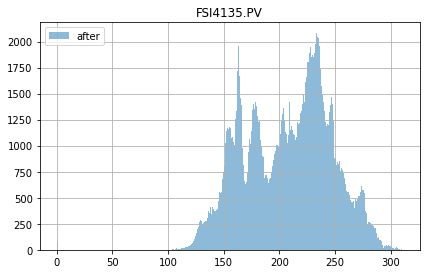

In [15]:
# 可視化(Visualization)
num_row = math.ceil(len(df.columns) / 2)

plt.figure(figsize=(15, 5 * num_row))
i = 0

for tag in list_y:
    i += 1
    plt.subplot(num_row, 2, i)
    n_raw, bins_raw, patches_raw = plt.hist(x=df[tag], bins= 500, alpha= 0.5, label="after")
    plt.legend(loc="upper left")
    plt.grid()
    plt.title(label=tag)
    mode_index_raw = n_raw.argmax()

plt.show()

In [16]:
sc_x = preprocessing.StandardScaler()
sc_y = preprocessing.StandardScaler()

In [17]:
x = df_x.values
y = df_y.values

### TOKI Comment

- x_scaled.mean, y_scaled.mean は何の為？  
  (What are x_scaled.mean and y_scaled.mean for?)

Nomura: Check if standardization is done correctly. If done, the average will be 0.

In [18]:
x_scaled = sc_x.fit_transform(x)
y_scaled = sc_y.fit_transform(y)

x_scaled.mean(axis=0), y_scaled.mean(axis=0)

(array([ 6.69301837e-15, -5.05031896e-15, -6.46783871e-15, -1.64748046e-14,
        -5.77303791e-15, -3.30660973e-15, -1.56444833e-16,  7.00716923e-15,
        -7.77810001e-16,  6.88838810e-16, -1.10526067e-16,  2.31898365e-15,
        -1.14882904e-15,  2.28206519e-15, -2.12778731e-14, -2.31141651e-15,
        -1.46756604e-17,  2.28940302e-15, -2.10687450e-15, -2.04608516e-14,
        -2.15631313e-14,  1.53800921e-14, -1.07246974e-14,  9.17228775e-17,
        -3.10023326e-16, -7.81478916e-16,  7.33783020e-18,  1.99955873e-15,
        -9.63090214e-17,  1.23243444e-14, -1.45564207e-15,  3.29835467e-15,
        -8.96361820e-15, -2.69665260e-16,  6.74449783e-15, -2.44900083e-16,
        -4.27061718e-15,  1.37584316e-18, -3.17361156e-16, -5.58821631e-16,
        -2.11879847e-16, -5.72350755e-16,  1.51296886e-15, -1.91196338e-15,
         5.61344010e-16, -1.26577571e-16, -8.16333610e-17, -1.39418774e-15,
         1.41161508e-15,  1.04506754e-16, -7.86752982e-16, -1.09150224e-15,
        -2.7

In [20]:
# Scalerの保存
from pickle import dump
#dump(sc_x, open('../../AImodel/FSI4135/FSI4135_sc_x_C03.pkl', 'wb'))
#dump(sc_y, open('../../AImodel/FSI4135/FSI4135_sc_y_C03.pkl', 'wb'))

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.1, random_state=0)

In [22]:
input_dim = x_train.shape[1]
output_dim = y_train.shape[1]

model = Sequential()
model.add(Dense(units=200, input_dim=input_dim))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(units=400))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(units=700))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(units=400))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(units=200))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(units=50))
model.add(LeakyReLU(alpha=0.3))

model.add(Dense(units=output_dim))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               12800     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               80400     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 700)               280700    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 700)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 400)              

### Modified by TOKI

In [28]:
#model_path_out = '../../AImodel/FSI4135/FSI4135_C03.h5'
model_dir =r'..\..\..\AImodel\FSI4135'
file = "FSI4135_C03.h5"

if not(os.path.isdir(model_dir)):
    #os.mkdir(model_dir)
    os.makedirs(model_dir)
print('\n# Save Model Dir. Path : ',os.path.abspath(model_dir))

model_path_out = os.path.join(model_dir,file)
#mc = ModelCheckpoint(filepath=model_path_out, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
mc = ModelCheckpoint(filepath=model_path_out, monitor='val_loss', verbose=0, save_best_only=True, mode='min')


# Save Model Dir. Path :  C:\Users\BF427\OneDrive - Chiyoda Corporation\Documents\_10008948_IoT_Process_fusion\FY_2021\MonitoringAI_CPW-main_20210818\AImodel\FSI4135


### TOKI Comment
- epochs=1000 => early stopping 機能を用いて早期終了を計ることを推奨  
  (epochs = 1000 => It is recommended to use the early stopping function to measure early stopping.)

In [31]:
#history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=1000, verbose=1, callbacks=[mc], validation_data=(x_test, y_test))
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, verbose=0, callbacks=[mc], validation_data=(x_test, y_test))

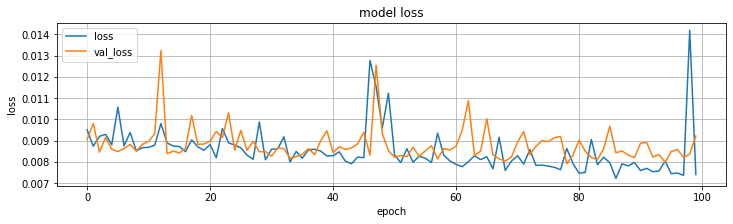

In [34]:
#fig = plt.figure(figsize=(12, 9))
fig = plt.figure(figsize=(12, 3))
plt.plot(history.history['loss'],"-",label="loss",)
plt.plot(history.history['val_loss'],"-",label="val_loss")
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [39]:
model_best = load_model(model_path_out)
#print(type(model_best))

In [37]:
y_pred = model_best.predict(x_test)
y_pred_inv = sc_y.inverse_transform(y_pred)
y_test_inv = sc_y.inverse_transform(y_test)

In [40]:
# 予測精度の評価
mtrc = metrics(y_true=y_test_inv, y_pred=y_pred_inv)
print("r2       : %.4f" % mtrc[0])
print("rmse     : %.4f" % mtrc[1])
print("rmse/avg.: %.6f" % (mtrc[1] / abs(y_test_inv.mean())))
print("mae      : %.4f" % mtrc[2])
print("mae/avg. : %.6f" % (mtrc[2] / abs(y_test_inv.mean())))

r2       : 0.9921
rmse     : 3.4475
rmse/avg.: 0.016603
mae      : 2.2447
mae/avg. : 0.010811


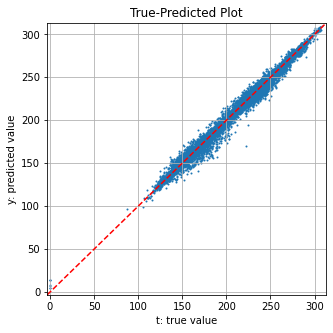

In [43]:
# テストデータの正解値と予測値のプロット
for i in range (0,1):
    fig = yyplot(y_true = y_test_inv[:,i], y_pred = y_pred_inv[:,i])

### TOKI Comment

- クロスバリデーション版でのコメント同様に、下図のような精度比較図が欲しい。どの時点が精度低かを知る  
  (Similar to the comments in the cross-validation version, I would like an accuracy comparison chart like the one below. Know which time point is less accurate)

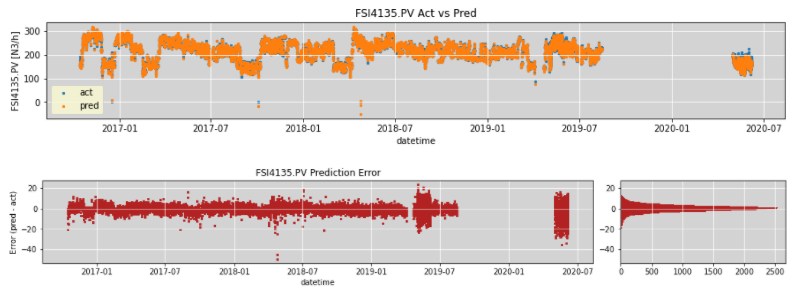